In [1]:
import os
import xml.etree.ElementTree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize

import numpy as np
from PIL import Image

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ROOT_DIR = os.path.abspath("../../")
MODEL_DIR = os.path.join(ROOT_DIR, "model")
print(MODEL_DIR)

c:\Users\user\model


In [2]:
class NoduleConfig(mrcnn.config.Config):
    NAME = "nod"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    #RPN_ANCHOR_SCALES = (2, 4, 8, 16, 64)
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10

    SAVE_EPOCHES_FREQ_PER_STEP = 2

In [3]:
# class InferenceConfig(KangarooConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1


class InferenceConfig(NoduleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # POST_NMS_ROIS_INFERENCE  = 200
    DETECTION_MIN_CONFIDENCE = 0.01
    DETECTION_MAX_INSTANCES  = 500
    DETECTION_NMS_THRESHOLD   = 0.99
    RPN_NMS_THRESHOLD = 0.99
    # PRE_NMS_LIMIT  = 12000
    DETECTION_MIN_SUPPRESSION_THRESHOLD = 0.001

inference_config = InferenceConfig()

#Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
                        #   x_cord= 110,
                        #   y_cord=227)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()

# Load trained weights

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
anchors :  Tensor("Squeeze_1:0", shape=(None, None, 4), dtype=float32)


In [4]:
MODEL_DIR = 'C:/Users/user/Desktop/Mask-RCNN_forTrain3/model/'
model_path = os.path.join(MODEL_DIR, "mask_rcnn_trained_1008_testingminus15.h5")
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  C:/Users/user/Desktop/Mask-RCNN_forTrain3/model/mask_rcnn_trained_1008_testingminus15.h5


In [5]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

(279, 4)
(65472, 1)


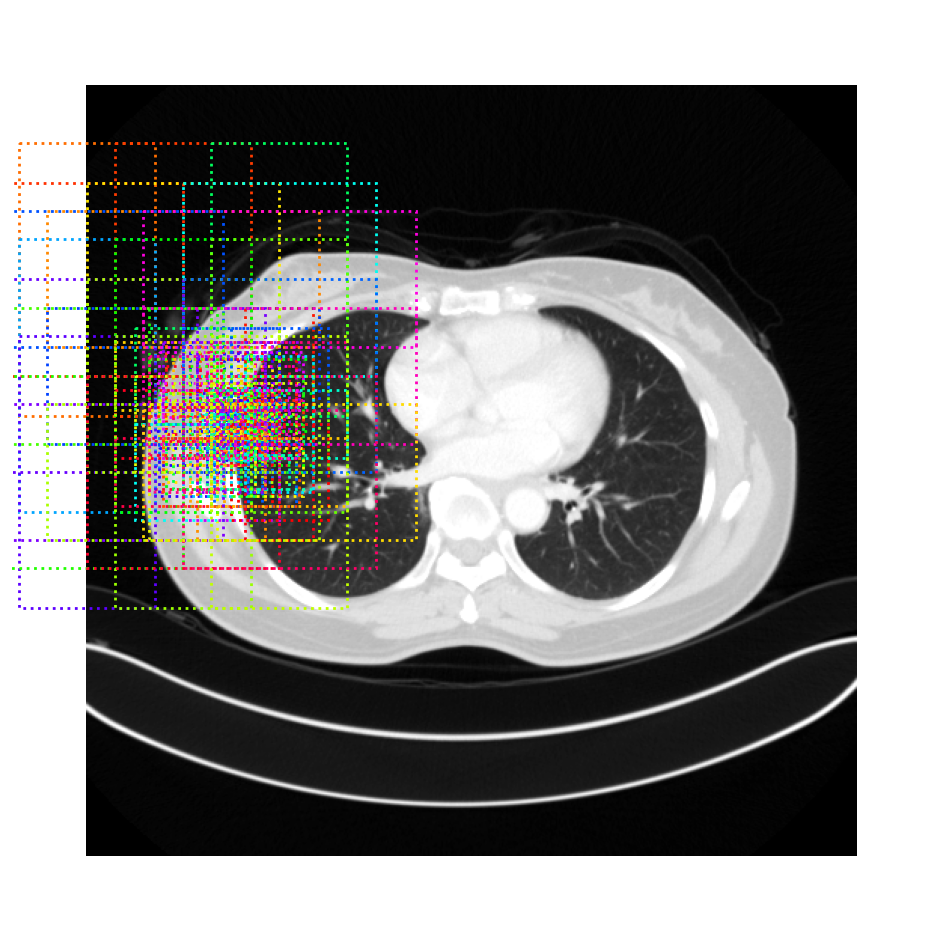

In [6]:
#! 過濾方法(無用)
import tensorflow as tf
import cv2
backbone_shapes = mrcnn.model.compute_backbone_shapes(model.config, model.config.IMAGE_SHAPE)
image = cv2.imread("C:/Users/user/Desktop/hospital/Tumor_original/001/001/0060.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def generate_coord_anchors(x,y,scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)
    # print(box_widths.shape)
    # print(box_centers_x.shape)

    # anchor_x = x//feature_stride*(feature_stride)+feature_stride
    # anchor_y = y//feature_stride*(feature_stride)+feature_stride
    # anchor_coord = np.array([anchor_y,anchor_x])

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    # print('ori_box_centers : ',box_centers.shape)
    #print('scale feature_stride : ',scales,feature_stride)
    if(feature_stride>=32):
        anchor_coord = []
        for a in range(-1,2):
            for b in range(-1,2):
                #print(a,b)
                anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
                anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
                anchor_coord.append([anchor_y,anchor_x])
        anchor_coord = np.array(anchor_coord)

        # anchor_x = x//feature_stride*(feature_stride)
        # anchor_y = y//feature_stride*(feature_stride)
        # anchor_coord = np.array([-1,-1])
    else:
        anchor_coord = []
        for a in range(-2,3):
            for b in range(-2,3):
                #print(a,b)
                anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
                anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
                anchor_coord.append([anchor_y,anchor_x])
        anchor_coord = np.array(anchor_coord)
    #print('anchor_coord : ',anchor_coord.shape)


    choose_anchor_tmp = []
    for c in range(anchor_coord.shape[0]):
        choose_anchor_tmp.append(np.all(box_centers == anchor_coord[c], axis=1))

    choose_anchor = choose_anchor_tmp[0]
    for c in range(len(choose_anchor_tmp)-1):
        choose_anchor = choose_anchor | choose_anchor_tmp[c+1]

    choose_anchor = np.array(choose_anchor)
    #print('choose_anchor : ',choose_anchor)
    box_centers = box_centers[choose_anchor] #for anchor
    #print('now_box_centers : ',box_centers.shape)

    box_heights = box_heights[:box_centers.shape[0]//3]
    #print('box_heights : ',box_heights.shape)
    box_widths = box_widths[:box_centers.shape[0]//3]
    # print(box_centers.shape)
    # print('box_centers : ')
    # for i in box_heights:
    #     print(i)
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])
    #print('box_sizes',box_sizes.shape)
    # for i in box_sizes:
    #     print(i)
    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    # print('boxes : ')
    # for i in boxes:
    #     print(i)

    
    return boxes,choose_anchor

def generate_coord_pyramid_anchors(x,y,scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    choose_anchors = []
    #print('scales : ',scales)
    for i in range(len(scales)):
        anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[0])
        choose_anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[1])
    anchors = np.concatenate(anchors, axis=0)
    choose_anchors = np.concatenate(choose_anchors, axis=0).astype(int)
    choose_anchors = np.expand_dims(choose_anchors,axis=1)
    #anchors = np.expand_dims(anchors,axis=0)
    return anchors,choose_anchors

anchor,choose_anchors = generate_coord_pyramid_anchors(110,229,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
print(anchor.shape)
print(choose_anchors.shape)
choose_anchors = np.expand_dims(choose_anchors,axis=0)

mrcnn.visualize.draw_boxes(image,anchor)

# generate_anchors(220,226,model.config.RPN_ANCHOR_SCALES[0], model.config.RPN_ANCHOR_RATIOS, backbone_shapes[0],
#                                         model.config.BACKBONE_STRIDES[0], model.config.RPN_ANCHOR_STRIDE)

(135, 4)
(65472, 1)


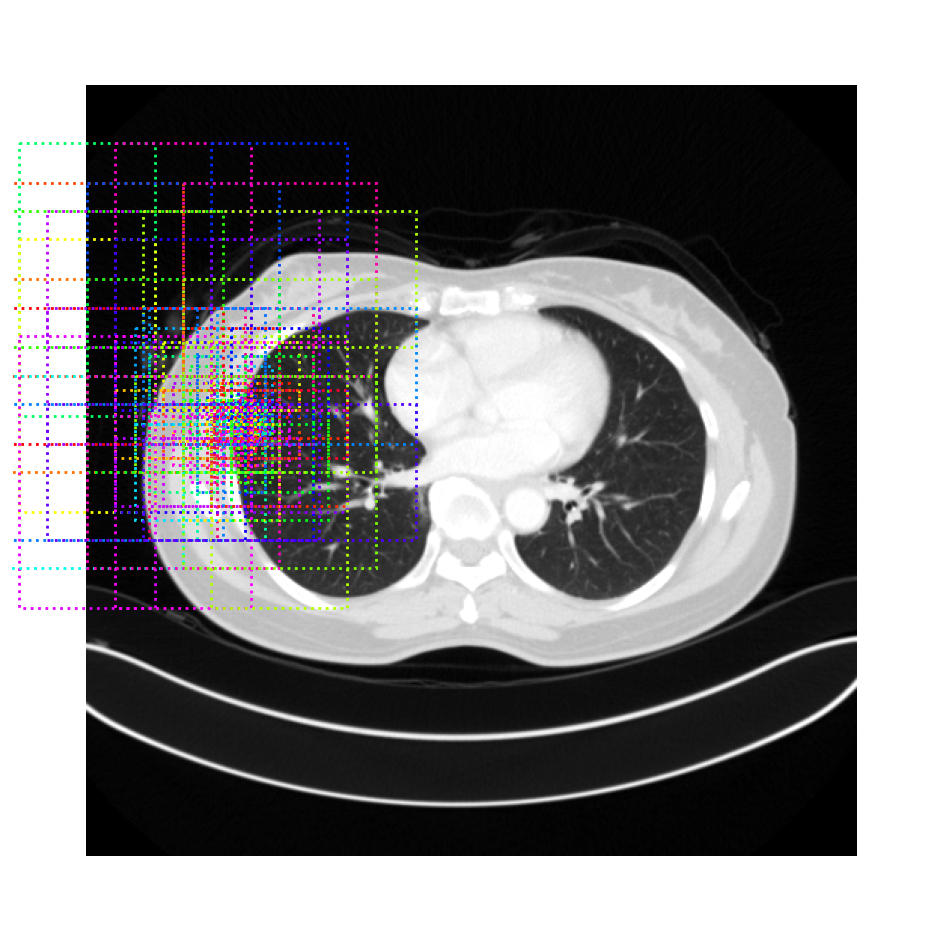

In [8]:
import tensorflow as tf
import cv2
backbone_shapes = mrcnn.model.compute_backbone_shapes(model.config, model.config.IMAGE_SHAPE)
image = cv2.imread("D:/dataset/Hospital_data/nodule/final/image/001/001/0060.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def generate_coord_anchors(x,y,scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)
    # print(box_widths.shape)
    # print(box_centers_x.shape)

    # anchor_x = x//feature_stride*(feature_stride)+feature_stride
    # anchor_y = y//feature_stride*(feature_stride)+feature_stride
    # anchor_coord = np.array([anchor_y,anchor_x])

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    # print('ori_box_centers : ',box_centers.shape)

    anchor_coord = []
    for a in range(-1,2):
        for b in range(-1,2):
            #print(a,b)
            anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
            anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
            anchor_coord.append([anchor_y,anchor_x])
    anchor_coord = np.array(anchor_coord)
    #print('anchor_coord : ',anchor_coord.shape)


    choose_anchor_tmp = []
    for c in range(9):
        choose_anchor_tmp.append(np.all(box_centers == anchor_coord[c], axis=1))

    choose_anchor = choose_anchor_tmp[8]
    for c in range(8):
        choose_anchor = choose_anchor | choose_anchor_tmp[c]

    choose_anchor = np.array(choose_anchor)
    #print('choose_anchor : ',choose_anchor)
    box_centers = box_centers[choose_anchor] #for anchor
    #print('now_box_centers : ',box_centers.shape)

    box_heights = box_heights[:box_centers.shape[0]//3]
    #print('box_heights : ',box_heights.shape)
    box_widths = box_widths[:box_centers.shape[0]//3]
    # print(box_centers.shape)
    # print('box_centers : ')
    # for i in box_heights:
    #     print(i)
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])
    #print('box_sizes',box_sizes.shape)
    # for i in box_sizes:
    #     print(i)
    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    # print('boxes : ')
    # for i in boxes:
    #     print(i)

    
    return boxes,choose_anchor

def generate_coord_pyramid_anchors(x,y,scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    choose_anchors = []
    for i in range(len(scales)):
        anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[0])
        choose_anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[1])
    anchors = np.concatenate(anchors, axis=0)
    choose_anchors = np.concatenate(choose_anchors, axis=0).astype(int)
    choose_anchors = np.expand_dims(choose_anchors,axis=1)
    #anchors = np.expand_dims(anchors,axis=0)
    return anchors,choose_anchors

anchor,choose_anchors = generate_coord_pyramid_anchors(110,229,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
print(anchor.shape)
print(choose_anchors.shape)
choose_anchors = np.expand_dims(choose_anchors,axis=0)
mrcnn.visualize.draw_boxes(image,anchor)

# generate_anchors(220,226,model.config.RPN_ANCHOR_SCALES[0], model.config.RPN_ANCHOR_RATIOS, backbone_shapes[0],
#                                         model.config.BACKBONE_STRIDES[0], model.config.RPN_ANCHOR_STRIDE)

In [11]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
image = cv2.imread("D:/Hospital_data/nodule/partial/image/001/0062.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flatLayer = Model(inputs=model.keras_model.input, outputs=model.keras_model.get_layer("roi_align_classifier").output)
molded_images, image_metas, windows = model.mold_inputs([image])
image_shape = molded_images[0].shape
anchors = model.get_anchors(image_shape)
anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)

flatResult = flatLayer.predict([molded_images, image_metas, anchors], verbose=0)


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), for inputs ['input_image', 'input_image_meta', 'choose_anchor', 'input_anchors'] but instead got the following list of 3 arrays: [array([[[[-123.7, -116.8, -103.9],
         [-123.7, -116.8, -103.9],
         [-123.7, -116.8, -103.9],
         ...,
         [-123.7, -116.8, -103.9],
         [-123.7, -116.8, -103.9],
         [...

(1, 1000, 7, 7, 256)
(1000, 7, 7, 256)


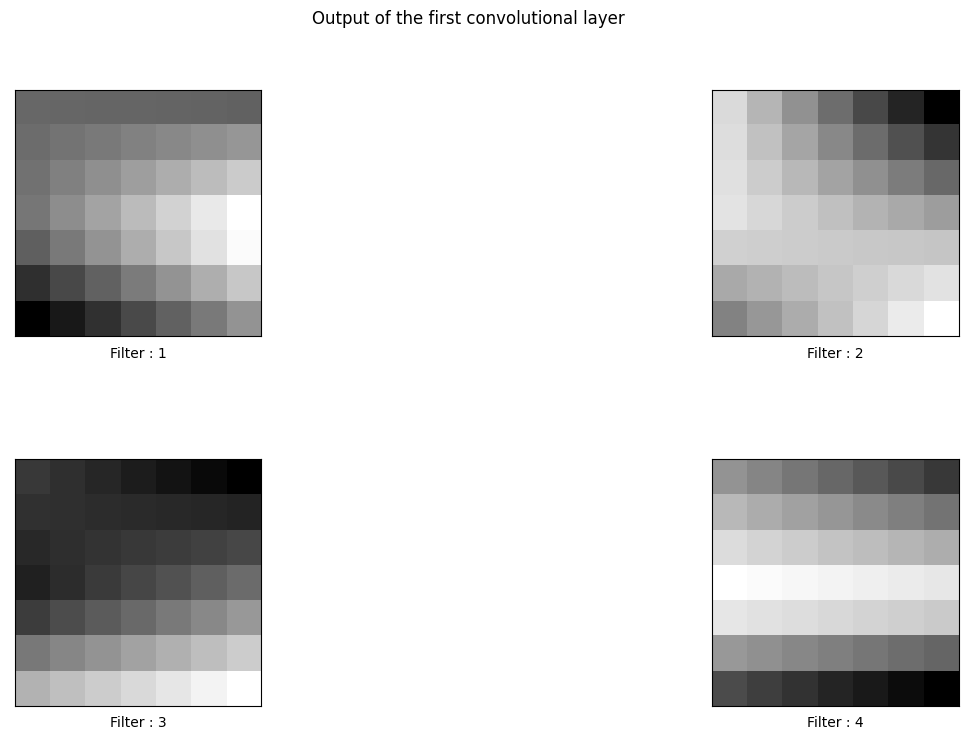

[[[[[-7.41839230e-01  2.66276654e-02  1.34961474e+00 ...
     -5.25149941e-01  3.78429919e-01  1.07901657e+00]
    [-7.50345409e-01 -6.24380037e-02  1.27123940e+00 ...
     -6.91880465e-01  5.03500104e-01  1.02916133e+00]
    [-7.58851528e-01 -1.51503682e-01  1.19286394e+00 ...
     -8.58610988e-01  6.28570199e-01  9.79306102e-01]
    ...
    [-7.75863886e-01 -3.29635024e-01  1.03611326e+00 ...
     -1.19207191e+00  8.78710508e-01  8.79595637e-01]
    [-7.84370065e-01 -4.18700695e-01  9.57737923e-01 ...
     -1.35880256e+00  1.00378072e+00  8.29740465e-01]
    [-7.92876244e-01 -5.07766366e-01  8.79362464e-01 ...
     -1.52553308e+00  1.12885094e+00  7.79885173e-01]]

   [[-6.93004370e-01  3.44978422e-02  1.28396058e+00 ...
      3.10400367e-01 -2.99783140e-01  1.13243556e+00]
    [-6.24669313e-01 -3.44418623e-02  1.26559711e+00 ...
      1.44044816e-01 -1.36882782e-01  1.07766521e+00]
    [-5.56334138e-01 -1.03381574e-01  1.24723339e+00 ...
     -2.23107338e-02  2.60174274e-02  1.02289

In [ ]:
import numpy as np
print(flatResult.shape)
conv1_img_ = flatResult
conv1_img_ = conv1_img_.squeeze(axis=0) #roi_align_classifier]
print(np.array(conv1_img_).shape)

conv1_img_ = conv1_img_[0,:,:,:]

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    #ax.imshow(conv1_img_[0,:,:,i], cmap='gray') #fpn
    ax.imshow(conv1_img_[:,:,i], cmap='gray') #roi_align_classifier
    xlabel = "Filter : {}".format(i+1)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])      
fig.suptitle('Output of the first convolutional layer')  
plt.show()
print(flatResult)

In [ ]:
print(anchor.shape)
zero_np = np.zeros((65466,4))
print(zero_np.shape)
anchorsss = np.tile(anchor, (int(65472/anchor.shape[0]), 1))
print(anchorsss.shape)
anchorsss = np.append(anchorsss,anchor[0:(65472-int(65472/anchor.shape[0])*anchor.shape[0])],axis=0)
print("anchorsss",anchorsss.shape)
#anchor = np.append(anchor,zero_np,axis=0)
print(anchorsss.shape)
print(anchor)
print(anchorsss)

(6, 4)
(65466, 4)
(65472, 4)
anchorsss (65472, 4)
(65472, 4)
[[0.427286   0.20581521 0.44746938 0.21492843]
 [0.43052837 0.2035225  0.444227   0.21722114]
 [0.4328211  0.20028013 0.4419343  0.22046351]
 [0.41621584 0.19245234 0.45853955 0.21263573]
 [0.42270058 0.18786693 0.4520548  0.21722114]
 [0.427286   0.18138218 0.44746938 0.22370589]]
[[0.427286   0.20581521 0.44746938 0.21492843]
 [0.43052837 0.2035225  0.444227   0.21722114]
 [0.4328211  0.20028013 0.4419343  0.22046351]
 ...
 [0.41621584 0.19245234 0.45853955 0.21263573]
 [0.42270058 0.18786693 0.4520548  0.21722114]
 [0.427286   0.18138218 0.44746938 0.22370589]]


In [ ]:
from skimage import io
img = io.imread('C:/Users/user/Desktop/hospital/0061.tif')
print(img[img>255])

[827 636 668 ... 732 668 604]


In [9]:
import cv2
image = cv2.imread("D:/Hospital_data/nodule/partial/image/001/0062.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image[image>30] +=50
print(image[image>254])

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255]


In [9]:
import numpy as np
print(img.shape)
new_img = np.zeros((img.shape[0],img.shape[1],3))
new_img[:,:,0] = img
new_img[:,:,1] = img
new_img[:,:,2] = img
print(new_img.shape)
print(image.shape)
print(new_img[new_img>255])

NameError: name 'img' is not defined

In [11]:
molded_images, image_metas, windows = model.mold_inputs([image])
print(molded_images.shape)
print(image_metas)


(1, 512, 512, 3)
[[  0 512 512   3 512 512   3   0   0 512 512   1   0   0]]


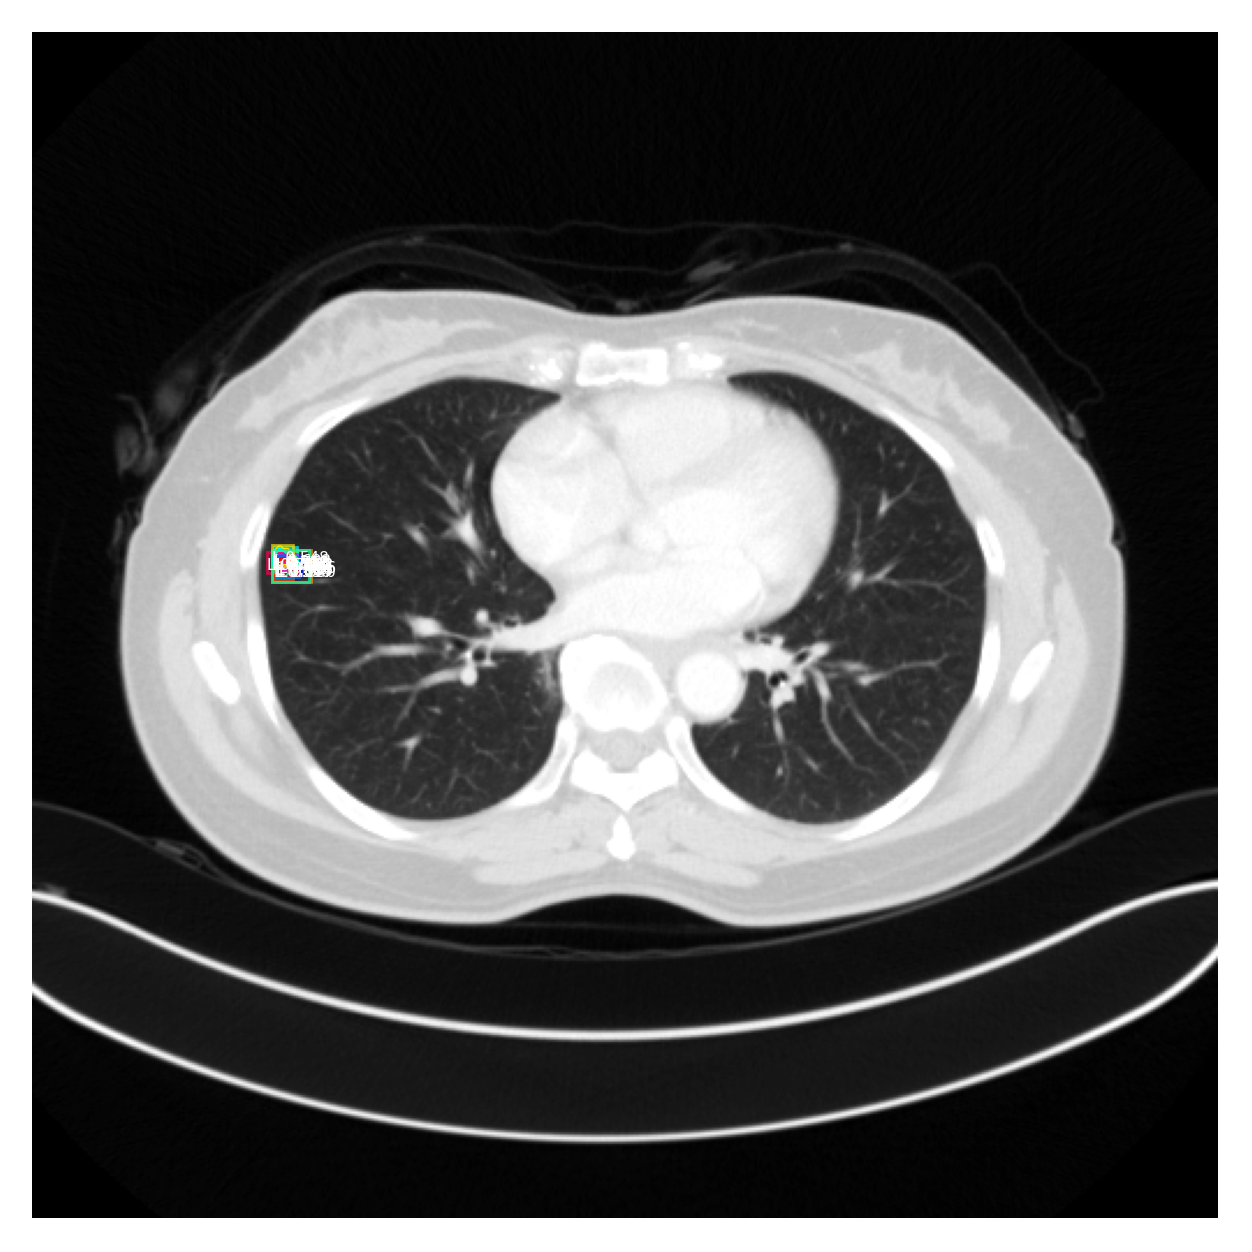

In [10]:
import cv2
image = cv2.imread("D:/dataset/Hospital_data/nodule/final/image/001/001/0060.png")
#image[image>40] +=50
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Perform a forward pass of the network to obtain the results
r = model.detect_specific_anchor([image],choose_anchors)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names='CLASS_NAMES', 
                                  scores=r['scores'])
# print('-'*50)
# print(r['rois'])
# print('-'*50)
# print(r['masks'])
# print('-'*50)
# print(r['class_ids'])
# print('-'*50)
# print(r['scores'])
# print('-'*50)

final_mask = np.zeros([512,512])
mask = np.zeros([512,512])
idx = 0
dice  = 0
for i in range(r['masks'].shape[2]):
    mask+=r['masks'][:,:,i]
mask[mask<int(r['masks'].shape[2]//2)] = 0
mask[mask>0]=1
for i in range(r['masks'].shape[2]):
    if(dice<2*np.sum(r['masks'][:,:,i]*mask)/(np.sum(r['masks'][:,:,i])+np.sum(mask))):
        dice = 2*np.sum(r['masks'][:,:,i]*mask)/(np.sum(r['masks'][:,:,i])+np.sum(mask))
        final_mask = r['masks'][:,:,i].astype(np.uint8)
final_mask*=255
#cv2.imwrite('C:/Users/user/Desktop/0712img/test.png',final_mask)

In [7]:
import pandas as pd

#! Dice
def dicee(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    
    if union == 0:
        return 1
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return 2.0 * intersection / union

#! Coverage
def coverage(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return intersection / np.sum(y_true_f)

def precision(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    return intersection / np.sum(y_pred_f)

# df_erode = pd.DataFrame(columns=["patient_id", "nodule_no", "image_no", "dice", "coverage", "precision"])
df_remove = pd.DataFrame(columns=["patient_id", "nodule_no", "image_no", "dice", "coverage", "precision"])
# df_dilate = pd.DataFrame(columns=["patient_id", "nodule_no", "image_no", "dice", "coverage", "precision"])

In [10]:
import pandas as pd
nodulescsv = pd.read_csv("C:/Users/user/Desktop/nodule/nodules.csv")
dataset_dir = 'C:/Users/user/Desktop/nodule/final'
save_mask_path = 'C:/Users/user/Desktop/0715_32'

get = 0
non_get = 0
all_dice = 0

#testing = [1, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 46, 54, 62, 68, 86, 113, 130, 133, 138, 141, 147, 155, 172, 185, 196]
testing = [1,3,7, 8, 12, 18, 21, 22, 23, 26, 27, 28, 29, 33, 34, 38, 39, 40, 42, 43]
images_dir = dataset_dir + '/image/'
mask_dir = dataset_dir + '/mask/'
for fordername in os.listdir(images_dir):
    if int(fordername) not in testing:#< 150
        continue
    for filename in os.listdir(images_dir+fordername):

        for imagename in os.listdir(images_dir+fordername+'/'+filename):
            img_id = imagename[:4]
            img_path = images_dir + fordername+'/'+filename+'/'+imagename
            print(img_path)
            index_loc = nodulescsv.loc[(nodulescsv['patientID'] ==int(fordername)) &(nodulescsv['num'] ==int(filename)) &(nodulescsv['filename'] == int(img_id))]
            x,y = index_loc.iloc[0]['cordX'],index_loc.iloc[0]['cordY']
            image = cv2.imread(img_path)
            #---------------------------------------------------------
            # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # pixel_value = gray_image[x,y]
            # print('pixel_value',pixel_value)
            # # 僅處理灰度值大於50的像素
            # adjusted_gray_image = np.where(gray_image > pixel_value-10, np.clip(gray_image + 50, 0, 255), gray_image)
            # # 將灰度圖像轉換回彩色圖像
            # image = cv2.cvtColor(adjusted_gray_image, cv2.COLOR_GRAY2BGR)
            # #---------------------------------------------------------
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Perform a forward pass of the network to obtain the results
            anchor,choose_anchors = generate_coord_pyramid_anchors(x,y,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
            choose_anchors = np.expand_dims(choose_anchors,axis=0)
            r = model.detect_specific_anchor([image],choose_anchors)

            # Get the results for the first image.
            r = r[0]
            # Visualize the detected objects.
            # mrcnn.visualize.display_instances(image=image, 
            #                                 boxes=r['rois'], 
            #                                 masks=r['masks'], 
            #                                 class_ids=r['class_ids'], 
            #                                 class_names='CLASS_NAMES', 
            #                                 scores=r['scores'])

            mask_path = mask_dir + fordername+'/'+filename+'/'+imagename
            mask = cv2.imread(mask_path,0)

            cnt = 0
            mask = mask/255
            got_bollean = 0
            concat_mask = np.zeros([512,512])
            # for i in range(r['masks'].shape[2]):
            #     concat_mask+=r['masks'][:,:,i]
            # concat_mask[concat_mask<int(r['masks'].shape[2]//4)] = 0
            # concat_mask[concat_mask>1]=1
            
            for i in range(r['masks'].shape[2]):
                if(r['masks'][:,:,i][y,x]==True):
                    concat_mask+=r['masks'][:,:,i]
                    got_bollean += 1
            print('got_bollean',got_bollean)

            #交集
            # concat_mask[concat_mask<got_bollean] = 0
            # concat_mask[concat_mask>0]=1

            #聯集
            #concat_mask[concat_mask>0]=1

            #2/3
            concat_mask[concat_mask<int(got_bollean//3)] = 0
            concat_mask[concat_mask>0]=1


            final_dice = 0
            final_coverage = 0
            final_precision = 0
            final_mask = np.zeros([512,512])

            dice = 0
            for i in range(r['masks'].shape[2]):
                if(r['masks'][:,:,i][y,x]==True):
                    if(dice<2*np.sum(r['masks'][:,:,i]*concat_mask)/(np.sum(r['masks'][:,:,i])+np.sum(concat_mask))):
                        dice = 2*np.sum(r['masks'][:,:,i]*concat_mask)/(np.sum(r['masks'][:,:,i])+np.sum(concat_mask))
                        final_mask = r['masks'][:,:,i].astype(np.uint8)           


            # concat_mask[concat_mask<got_bollean//2]=0
            # concat_mask[concat_mask>0]=1
            
            #final_dice = 2*np.sum(final_mask*mask)/(np.sum(final_mask)+np.sum(mask))
            final_dice = dicee(mask,final_mask)
            final_coverage = coverage(mask,final_mask)
            final_precision = precision(mask,final_mask)
            df_remove.loc[len(df_remove.index)] = [int(fordername), int(filename), int(img_id), round(final_dice, 3), round(final_coverage, 3),round(final_precision, 3)]
                                        
            
            # cnt+=1
            print('final_dice : ',final_dice)
            print('final_coverage : ',final_coverage)
            print('final_precision : ',final_precision)
            all_dice+=final_dice

            if(got_bollean):
                get+=1
            else:
                non_get+=1
                # mrcnn.visualize.display_instances(image=image, 
                #                             boxes=r['rois'], 
                #                             masks=r['masks'], 
                #                             class_ids=r['class_ids'], 
                #                             class_names='CLASS_NAMES', 
                #                             scores=r['scores'],
                #                             save_fig_path = 'C:/Users/user/Desktop/0715test/'+fordername+filename+imagename)


            print('all_dice non : ',all_dice/(non_get+get))
            print('all_dice : ',all_dice/(get))
            print('non_get : ',non_get)
            print('get : ',get)


            # final_mask = np.zeros([512,512])
            # mask = np.zeros([512,512])
            # idx = 0
            # dice  = 0
            # for i in range(r['masks'].shape[2]):
            #     mask+=r['masks'][:,:,i]
            # mask[mask<int(r['masks'].shape[2]//2)] = 0
            # mask[mask>0]=1
            # for i in range(r['masks'].shape[2]):
            #     if(dice<2*np.sum(r['masks'][:,:,i]*mask)/(np.sum(r['masks'][:,:,i])+np.sum(mask))):
            #         dice = 2*np.sum(r['masks'][:,:,i]*mask)/(np.sum(r['masks'][:,:,i])+np.sum(mask))
            #         final_mask = r['masks'][:,:,i].astype(np.uint8)
            #         print('dice'+str(i),dice)

            # final_mask*=255
            # if not os.path.isdir(save_mask_path+'/'+fordername+'/'+filename):
            #     os.makedirs(save_mask_path+'/'+fordername+'/'+filename)
            #     print("Create_file : "+save_mask_path+'/'+fordername+'/'+filename)
            # cv2.imwrite(save_mask_path+'/'+fordername+'/'+filename+'/'+imagename,final_mask)


            # if(~(np.any(mask)!=0)):
            #     non_get+=1
            # else:
            #     get+=1
            # print('non_get : ',non_get)
            # print('get : ',get)


            # print('-'*50)
            # print(r['rois'])
            # print('-'*50)
            # print(r['masks'])
            # print('-'*50)
            # print(r['class_ids'])
            # print('-'*50)
            # print(r['scores'])
            # print('-'*50)


print('non_get : ',non_get)
print('get : ',get)
print(all_dice/(non_get+get))
print(all_dice/(get))


C:/Users/user/Desktop/nodule/final/image/001/001/0060.png
got_bollean 19
final_dice :  0.7428571428571429
final_coverage :  0.6419753086419753
final_precision :  0.8813559322033898
all_dice non :  0.7428571428571429
all_dice :  0.7428571428571429
non_get :  0
get :  1
C:/Users/user/Desktop/nodule/final/image/001/001/0061.png
got_bollean 6
final_dice :  0.8370607028753994
final_coverage :  0.7401129943502824
final_precision :  0.9632352941176471
all_dice non :  0.7899589228662711
all_dice :  0.7899589228662711
non_get :  0
get :  2
C:/Users/user/Desktop/nodule/final/image/001/001/0062.png
got_bollean 5
final_dice :  0.8776119402985074
final_coverage :  0.8076923076923077
final_precision :  0.9607843137254902
all_dice non :  0.8191765953436833
all_dice :  0.8191765953436833
non_get :  0
get :  3
C:/Users/user/Desktop/nodule/final/image/001/001/0063.png
got_bollean 13
final_dice :  0.6744186046511628
final_coverage :  0.5523809523809524
final_precision :  0.8656716417910447
all_dice non :

c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


got_bollean 10
final_dice :  0.7974683544303798
final_coverage :  0.8076923076923077
final_precision :  0.7875
all_dice non :  0.8002489563352266
all_dice :  0.838356049494047
non_get :  1
get :  21
C:/Users/user/Desktop/nodule/final/image/003/003/0022.png
got_bollean 14
final_dice :  0.7050359712230215
final_coverage :  0.8596491228070176
final_precision :  0.5975609756097561
all_dice non :  0.7961092613303482
all_dice :  0.832296045936273
non_get :  1
get :  22
C:/Users/user/Desktop/nodule/final/image/003/003/0023.png
got_bollean 10
final_dice :  0.6428571428571429
final_coverage :  1.0
final_precision :  0.47368421052631576
all_dice non :  0.7897237563939646
all_dice :  0.8240595718893544
non_get :  1
get :  23
C:/Users/user/Desktop/nodule/final/image/003/004/0036.png
got_bollean 13
final_dice :  0.6111111111111112
final_coverage :  1.0
final_precision :  0.44
all_dice non :  0.7825792505826504
all_dice :  0.8151867193569275
non_get :  1
get :  24
C:/Users/user/Desktop/nodule/final/

In [11]:

with pd.ExcelWriter(engine='openpyxl', path='C:/Users/user/Desktop/extra_test/testing_minus15.xlsx', mode='a') as writer:
    df_remove.to_excel(writer, sheet_name='two_of_three', index=False)

In [ ]:
import matplotlib.pyplot as plt
truemask = cv2.imread('//tsclient/C/Users/aa235/Desktop/partial/mask/001/0061.png')
mask = np.zeros((512,512))
mask[r['masks'][:,:,2]==True]=255
print(mask.shape)
plt.figure(figsize=(10, 10))
plt.imshow(image, interpolation='nearest')
plt.figure(figsize=(10, 10))
plt.imshow(truemask, interpolation='nearest',cmap='gray')
plt.figure(figsize=(10, 10))
plt.imshow(mask, interpolation='nearest', cmap='gray')

# print(r['masks'][:,:,0].shape)
# for i in r['masks'][:,:,0]:
#     print(i)

IndexError: index 2 is out of bounds for axis 2 with size 0

In [ ]:
image_id = 0
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

NameError: name 'dataset' is not defined